# Procesamiento de Lenguaje Natural - **Trabajo Práctico 3**
# **Detectando *hate speech* en los medios sociales**

Detectar aquellos comentarios de Reddit que contienen hate speech distinguiéndolos de aquellos que no!




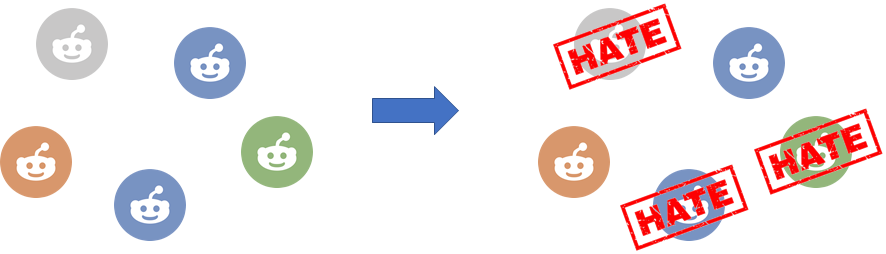

### Qué tienen que hacer?


1.    Pre-procesamiento. Selección de features léxicas.
2.    Features sintácticas & Pipeline.
**3.    Modelo de clasificación.**

Con los prácticos anteriores deberían haber integrado:
* Procesamiento de los json con los comentarios y almacenarlos en alguna estructura.
* Elección de las características para representar los comentarios.
* Elección de la representación para los comentarios. 

Ahora, para este práctico:

* Entrenar modelos de clasificación de *hate speech*!

* Elegir una técnica de selección de características para aplicar.
* Elegir al menos dos clasificadores para entrenar.
  * Realizar optimización de parámetros.
* Reportar resultados la clasificación con los diferentes clasificadores:
  * Aplicando o no pre-procesamiento.
  * Aplicando o no feature selection (sobre la variante con pre-procesamiento).




## 1.1 Lectura de datos

Realizo la lectura de los datos suministrados. Los mismos son almacenados en DataFrames de Pandas

In [1]:
#Importo los modulos que voy a utilizar

#Principales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

#Preprocesamiento y representacion de texto
import functools
import pathlib
import shutil
import requests
from tqdm.auto import tqdm as tqdmauto
import requests
from collections import Counter
import re
import string
import unicodedata
import os
import nltk
from nltk import word_tokenize
from nltk import ngrams
from nltk import pos_tag
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
from textblob import TextBlob
from tqdm.notebook import tqdm

#Reduccion de dimensiones y Modelos
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

#Metricas
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Spacy

In [2]:
#Instalo spacy

! pip install spacy

In [3]:
#Bajo el modelo para spacy

!python -m spacy download en_core_web_lg

     |████████████████████████████████| 782.7 MB 5.8 kB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [4]:
#Imports correspondientes

import spacy 
import en_core_web_lg 

In [5]:
#Lectura del json correspondiente a reddit_comments

#URL del archivo
reddit_comments_url = "https://raw.githubusercontent.com/ccollado7/Diplomatura-Universitaria-en-Inteligencia-Artificial---UNICEN/main/Modulo%203%20-%20Procesamiento%20de%20Lenguaje%20Natural/TP's/TP%201/reddit_comments.json"

#Lectura del json
df_reddit_comments = pd.read_json(reddit_comments_url)

#Columnas del dataframe
df_reddit_comments.columns

Index(['_replies', 'id', 'total_awards_received', 'approved_at_utc',
       'comment_type', 'edited', 'mod_reason_by', 'banned_by',
       'author_flair_type', 'removal_reason', 'link_id',
       'author_flair_template_id', 'likes', 'user_reports', 'saved',
       'banned_at_utc', 'mod_reason_title', 'gilded', 'archived', 'no_follow',
       'author', 'can_mod_post', 'created_utc', 'send_replies', 'parent_id',
       'score', 'author_fullname', 'approved_by', 'mod_note', 'all_awardings',
       'subreddit_id', 'body', 'awarders', 'author_flair_css_class', 'name',
       'author_patreon_flair', 'downs', 'author_flair_richtext',
       'is_submitter', 'body_html', 'gildings', 'collapsed_reason',
       'distinguished', 'associated_award', 'stickied', 'author_premium',
       'can_gild', 'top_awarded_type', 'author_flair_text_color',
       'score_hidden', 'permalink', 'num_reports', 'locked', 'report_reasons',
       'created', 'subreddit', 'author_flair_text', 'treatment_tags',
       '

In [6]:
#URL del archivo
reddit_authors_url = "https://raw.githubusercontent.com/ccollado7/Diplomatura-Universitaria-en-Inteligencia-Artificial---UNICEN/main/Modulo%203%20-%20Procesamiento%20de%20Lenguaje%20Natural/TP's/TP%201/reddit_authors.json"

#Lectura del json
df_reddit_authors = pd.read_json(reddit_authors_url)

#Columnas del dataframe
df_reddit_authors.columns

Index(['_listing_use_sort', 'name', 'is_employee', 'is_friend', 'subreddit',
       'snoovatar_size', 'awardee_karma', 'id', 'verified', 'is_gold',
       'is_mod', 'awarder_karma', 'has_verified_email', 'icon_img',
       'hide_from_robots', 'link_karma', 'total_karma', 'pref_show_snoovatar',
       'created', 'created_utc', 'snoovatar_img', 'comment_karma',
       'has_subscribed'],
      dtype='object')

In [7]:
#URL del archivo
conversations_url = "https://raw.githubusercontent.com/ccollado7/Diplomatura-Universitaria-en-Inteligencia-Artificial---UNICEN/main/Modulo%203%20-%20Procesamiento%20de%20Lenguaje%20Natural/TP's/TP%201/conversations.csv"

#Lectura del csv
df_conversations = pd.read_csv(conversations_url,sep='\t')

#Columnas del dataframe
df_conversations.columns

Index(['e8q18lf,e8q9w5s,e8qbobk,e8qfn91'], dtype='object')

## 1.2 Features seleccionados para trabajar

De los 3 conjuntos de datos disponibles decido utilizar los indicados a continuacion

1) reddit_comments: De los features disponibles trabajo con los principales y considerados esenciales, correspondientes a:

  *   body: Texto de los comentarios
  *   is_hate: Categoria correspondiente a si el texto del comentario contiene hate speech

  Los features no seleccionados contienen en la mayoria de los casos elevados valores de NaN y considero no aportarian informacion relevante para el proceso de clasificacion

2) reddit_authors: No considero su uso para el proceso de clasificacion

3) conversations: No considero su uso para el proceso de clasificacion

In [8]:
#Me quedo con los features a trabajar

comments_utils = df_reddit_comments[['body','is_hate']]

#Del analisis exploratorio surgio que en la columna 'is_hate' tengo 10 NaN. Le doy tratamiento en forma temprana eliminando estos registros
comments_utils.dropna(inplace=True)
comments_utils.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,body,is_hate
0,A subsection of retarded Hungarians? Ohh boy. ...,1.0
1,Hiii. Just got off work. 444 is mainly the typ...,0.0
2,wow i guess soyboys are the same in every country,0.0
3,Owen Benjamin's soyboy song goes for every cou...,0.0
4,wouldn't the defenders or whatever they are as...,1.0


In [9]:
#Tamaño del nuevo DataFrame: Se eliminarn los 10 registros

comments_utils.shape

(18860, 2)

## 1.3 Pre-Procesamiento


Sobre el feature de texto correspondiente al comentario aplico todas las etapas de preprocesamiento consideradas necesarias.

Con respecto a las etapas de preprocesamiento definidas en el TP N°1 para este caso agregue etapas adicionales y modifique el orden de aplicacion segun lo recomendado en los comentarios

In [10]:
#Case conversion a minuscula

def minuscula(texto):
    return texto.lower()

In [11]:
#Remocion de URL's

def remover_url(texto):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', texto)

In [12]:
# Remocion de Emojis

def remover_emoji(texto):
    emoji_patrones = re.compile(
        '['
        u'\U0001F600-\U0001F64F' 
        u'\U0001F300-\U0001F5FF' 
        u'\U0001F680-\U0001F6FF' 
        u'\U0001F1E0-\U0001F1FF' 
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_patrones.sub(r'', texto)

In [13]:
#Eliminacion de caracteres especiales y numeros

def remover_caracteres_especiales(text, remove_digits=True):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text

In [14]:
#Expancion de abreviaturas

abreviaturas = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", 
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

def expandir_abreviaturas(texto,mapping = abreviaturas):
    texto = ' '.join([mapping[t] if t in mapping else t for t in texto.split(" ")])
    return texto

In [15]:
#Expancion de contracciones

contraction_mapping = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

def expandir_contracciones(sentence): 
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())),
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                   if contraction_mapping.get(match)\
                                     else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char + expanded_contraction[1:]
        return expanded_contraction
        
    expanded_sentence = contractions_pattern.sub(expand_match, sentence)
    return expanded_sentence

In [16]:
#Remocion de espacios en Blanco (extras/tabs)

def remover_espacio_extra(texto):
    import re
    pattern = r'^\s*|\s\s*'
    return re.sub(pattern, ' ', texto).strip()

In [17]:
#Eliminacion de stopwords

nltk_stopwords = nltk.corpus.stopwords.words('english')

def remover_stopwords(text,is_lower_case=False):
    tokens = ToktokTokenizer().tokenize(text)

    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in nltk_stopwords]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in nltk_stopwords]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

In [18]:
#Caracteristicas Lexicas: Decido realizar Stemming

#Defino una funcion para realizar stemming

porter=PorterStemmer()
def stemming(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

In [19]:
#Funcion para realizar el preprocesamiento en conjunto

def preprocesamiento(df, col_name, clean_col_name):
    df[clean_col_name] = df[col_name].apply(lambda x: minuscula (x))\
                                    .apply(lambda x: expandir_abreviaturas(x))\
                                    .apply(lambda x: expandir_contracciones(x))\
                                    .apply(lambda x: remover_url(x))\
                                    .apply(lambda x: remover_emoji(x))\
                                    .apply(lambda x: remover_caracteres_especiales(x))\
                                    .apply(lambda x: remover_espacio_extra(x))\
                                    .apply(lambda x: remover_stopwords(x))\
                                    .apply(lambda x: stemming(x))

In [20]:
#Aplico todas las etapas de proprocesamiento al texto de los comentarios

preprocesamiento(comments_utils,'body','body_preprocesado')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [21]:
#Observo los 5 primeros registros
comments_utils.head()

,body,is_hate,body_preprocesado
0,A subsection of retarded Hungarians? Ohh boy. ...,1.0,subsect retard hungarian ohh boy brace livid b...
1,Hiii. Just got off work. 444 is mainly the typ...,0.0,hiii got work mainli typa guy imagin write us ...
2,wow i guess soyboys are the same in every country,0.0,wow guess soyboy everi countri
3,Owen Benjamin's soyboy song goes for every cou...,0.0,owen benjamin soyboy song goe everi countri amaz
4,wouldn't the defenders or whatever they are as...,1.0,would defend whatev group divers group sinc kn...


# 2. Agregado de nuevas características


Para este caso elijo agregar, para los textos sin pre-procesar, la polaridad y subjetividad como nuevos atributos:

*   La polaridad toma valores entre -1 y 1: Valores cercanos a -1 representan emociones negativas y viceversa
*   La subjetividad toma valores entre 0 y 1: Valores cercanos a 0 representa alta objetividad y valores cercanos a 1 alta subjetividad


In [22]:
#Calculo la polaridad
def sentimiento_polaridad(texto):
  sent = TextBlob(texto)
  return sent.sentiment.polarity

#Calculo la subjetividad
def sentimiento_subjetividad(texto):
  sent = TextBlob(texto)
  return sent.sentiment.subjectivity

#Guardo en nuevos atributos los valores de polaridad y subjetividad
def sentimiento(df,col_name):
    df['polaridad'] = df[col_name].apply(lambda x: sentimiento_polaridad(x))
    df['subjetividad'] = df[col_name].apply(lambda x: sentimiento_subjetividad(x))

In [23]:
#Calculo la polaridad y subjetividad para el texto sin pre-procesar.

sentimiento(comments_utils,'body')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:
#Observo los 5 primeros registros

comments_utils.head()

,body,is_hate,body_preprocesado,polaridad,subjetividad
0,A subsection of retarded Hungarians? Ohh boy. ...,1.0,subsect retard hungarian ohh boy brace livid b...,-0.800000,0.850000
1,Hiii. Just got off work. 444 is mainly the typ...,0.0,hiii got work mainli typa guy imagin write us ...,0.117708,0.447917
2,wow i guess soyboys are the same in every country,0.0,wow guess soyboy everi countri,0.050000,0.562500
3,Owen Benjamin's soyboy song goes for every cou...,0.0,owen benjamin soyboy song goe everi countri amaz,0.600000,0.900000
4,wouldn't the defenders or whatever they are as...,1.0,would defend whatev group divers group sinc kn...,0.169048,0.478571


Sumado a lo anterior angrego features categoricos sobre la presencia (1) o no (0) de numeros y URL's en el texto:

In [25]:
#Funcion que examina la presencia de numeros en el texto original

def tiene_numero(string):
  if any(char.isdigit() for char in string):
    return 1.0
  else:
    return 0.0

In [26]:
def tiene_url(string):
    regex = (r'https?://\S+|www\.\S+')
    url = re.findall(regex,string)
    if len(url) == 0:
      return 0.0
    else:
      return 1.0

In [27]:
#Aplico la funcion de numeros

comments_utils['tiene_numero'] = comments_utils['body'].apply(lambda x: tiene_numero(x))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
#Aplico la funcion de URL's

comments_utils['tiene_url'] = comments_utils['body'].apply(lambda x: tiene_url(x))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [29]:
comments_utils.head()

,body,is_hate,body_preprocesado,polaridad,subjetividad,tiene_numero,tiene_url
0,A subsection of retarded Hungarians? Ohh boy. ...,1.0,subsect retard hungarian ohh boy brace livid b...,-0.800000,0.850000,0.0,0.0
1,Hiii. Just got off work. 444 is mainly the typ...,0.0,hiii got work mainli typa guy imagin write us ...,0.117708,0.447917,1.0,0.0
2,wow i guess soyboys are the same in every country,0.0,wow guess soyboy everi countri,0.050000,0.562500,0.0,0.0
3,Owen Benjamin's soyboy song goes for every cou...,0.0,owen benjamin soyboy song goe everi countri amaz,0.600000,0.900000,0.0,0.0
4,wouldn't the defenders or whatever they are as...,1.0,would defend whatev group divers group sinc kn...,0.169048,0.478571,1.0,0.0


# 3.Representación de los comentarios




En el TP N°2 eleji como representacion la correspondiente al tipo TF-IDF ya que iene en cuenta la importancia que tienen ciertas palabras en un texto en comparacion con todos los documentos disponibles. 

Debido a la enorme matriz rala que se forma con esta metodologia de Bag-of-words y despues de tener grandes problemas de memoria al ejecutar el Notebook(probe con Google Colab y Notebooks de Kaggle ampliando la memoria disponible) decidi pasar a una representacion compacta basadas en deep learning utilizando spacy

In [30]:
#Utilizo spacy como implementacion de Doc2Vec

nlp = spacy.load("en_core_web_lg")

## 3.1 Corpus sin Preprocesar

In [31]:
#El corpus en este caso corresponde al texto de todos los comentarios sin preprocesar (texto original)

corpus_nopre = comments_utils['body']

In [32]:
#Obtengo la representacion (vectores)

corpus_nopre_vect = np.array([nlp(str(doc)).vector for doc in corpus_nopre]) 

In [33]:
#Genero un DataFrame con la representacion vectorial de los comentarios obtenidas anteriormente

df_vect_nopre = pd.DataFrame(corpus_nopre_vect)
df_vect_nopre.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.064281,0.094247,-0.128640,-0.060126,0.149859,-0.108190,0.082686,-0.137890,-0.042515,1.728492,...,-0.048144,-0.054020,-0.009673,-0.246838,0.066206,0.091768,-0.113233,0.049516,-0.053882,0.123959
1,-0.033068,0.079401,-0.157825,-0.081586,0.116739,0.051430,0.028620,-0.072216,-0.021145,2.003678,...,-0.222334,-0.042012,-0.066304,-0.048371,0.032254,0.028288,-0.025731,-0.015221,-0.077988,0.046328
2,-0.031991,0.223558,-0.110949,-0.159136,0.135316,0.014811,0.039646,-0.107215,0.062004,2.075587,...,-0.152367,-0.000173,-0.065263,-0.205987,0.075755,0.035714,-0.130490,-0.044136,-0.019521,0.185693
3,-0.072297,0.341110,-0.043444,-0.101772,0.114798,0.023442,0.055991,-0.169863,-0.053116,2.050585,...,-0.051755,0.020020,0.037263,-0.061012,0.119709,-0.100053,0.007974,-0.045950,0.015451,0.130607
4,-0.044436,0.116801,-0.136605,-0.061253,0.084544,-0.010449,0.016948,-0.080963,-0.030091,2.210694,...,-0.261547,-0.022070,-0.029430,-0.067089,-0.005235,-0.043292,-0.048067,-0.110502,0.026515,0.063964


## 3.2 Corpus Preprocesado

In [34]:
#El corpus en este caso corresponde al texto de todos los comentarios preprocesados

corpus_pre = comments_utils['body_preprocesado']

In [35]:
#Obtengo la representacion (vectores)

corpus_pre_vect = np.array([nlp(str(doc)).vector for doc in corpus_pre]) 

In [36]:
#Genero un DataFrame con la representacion vectorial de los comentarios obtenidas anteriormente

df_vect_pre = pd.DataFrame(corpus_pre_vect)
df_vect_pre.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.211002,0.006469,-0.104968,-0.027616,0.191544,-0.108937,0.103239,-0.138022,-0.191535,0.781090,...,0.201484,-0.078511,-0.139948,-0.222806,0.209817,0.219934,-0.065413,0.156612,-0.046667,0.167060
1,-0.088029,0.040961,-0.148163,0.020652,0.193951,0.151614,0.068525,-0.116247,-0.058661,1.393393,...,-0.130193,-0.049884,-0.081093,-0.106847,0.186674,-0.046888,0.028252,0.072483,-0.100820,0.126264
2,-0.040052,0.162296,-0.056996,-0.211300,0.021480,0.101106,0.067526,-0.166712,0.052816,0.321034,...,0.123562,-0.101450,-0.139976,-0.100451,0.128513,-0.023523,-0.127997,-0.085223,-0.082108,0.124586
3,0.084796,0.107384,0.131513,-0.274275,0.213338,-0.130689,0.097748,-0.190484,-0.006235,-0.262350,...,0.219630,-0.157006,-0.056016,-0.118061,0.312868,-0.059696,0.066851,-0.054495,-0.122154,0.080362
4,0.013785,0.055677,-0.095593,-0.090313,0.011390,0.006364,0.005218,-0.119247,0.025366,1.596936,...,-0.123518,-0.079265,-0.089292,-0.162897,0.036452,-0.164153,-0.042742,0.011694,-0.014203,0.072142


# 4. Preparado de los datos para la utilización del modelo de clasificación


## 4.1 Integracion de representaciones Numericas y Categoricas

Integro la representacion basada en deep learning junto con los nuevos features generados: 

* Numericas: Polaridad y subjetividad

* Categoricas: tiene_numero y tiene_url

In [37]:
#Features numericos que me interesan

comments_utils_num= comments_utils[['polaridad','subjetividad']]
comments_utils_num.reset_index(inplace=True, drop=True)
comments_utils_num.head()

,polaridad,subjetividad
0,-0.800000,0.850000
1,0.117708,0.447917
2,0.050000,0.562500
3,0.600000,0.900000
4,0.169048,0.478571


### 4.1.1 Integracion de dataframes numericos - Sin Preprocesar

In [38]:
#Realizo la union de los dataframes numericos: 

x_num_nopre = pd.concat([df_vect_nopre, comments_utils_num], axis=1)

In [39]:
#Observo los 5 primeros registros

x_num_nopre.head()

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,polaridad,subjetividad
0,-0.064281,0.094247,-0.128640,-0.060126,0.149859,-0.108190,0.082686,-0.137890,-0.042515,1.728492,...,-0.009673,-0.246838,0.066206,0.091768,-0.113233,0.049516,-0.053882,0.123959,-0.800000,0.850000
1,-0.033068,0.079401,-0.157825,-0.081586,0.116739,0.051430,0.028620,-0.072216,-0.021145,2.003678,...,-0.066304,-0.048371,0.032254,0.028288,-0.025731,-0.015221,-0.077988,0.046328,0.117708,0.447917
2,-0.031991,0.223558,-0.110949,-0.159136,0.135316,0.014811,0.039646,-0.107215,0.062004,2.075587,...,-0.065263,-0.205987,0.075755,0.035714,-0.130490,-0.044136,-0.019521,0.185693,0.050000,0.562500
3,-0.072297,0.341110,-0.043444,-0.101772,0.114798,0.023442,0.055991,-0.169863,-0.053116,2.050585,...,0.037263,-0.061012,0.119709,-0.100053,0.007974,-0.045950,0.015451,0.130607,0.600000,0.900000
4,-0.044436,0.116801,-0.136605,-0.061253,0.084544,-0.010449,0.016948,-0.080963,-0.030091,2.210694,...,-0.029430,-0.067089,-0.005235,-0.043292,-0.048067,-0.110502,0.026515,0.063964,0.169048,0.478571


### 4.1.2 Integracion de dataframes numericos - Preprocesado

In [40]:
#Realizo la union de los dataframes numericos: 

x_num_pre = pd.concat([df_vect_pre, comments_utils_num], axis=1)

In [41]:
#Observo los 5 primeros registros

x_num_pre.head()

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,polaridad,subjetividad
0,-0.211002,0.006469,-0.104968,-0.027616,0.191544,-0.108937,0.103239,-0.138022,-0.191535,0.781090,...,-0.139948,-0.222806,0.209817,0.219934,-0.065413,0.156612,-0.046667,0.167060,-0.800000,0.850000
1,-0.088029,0.040961,-0.148163,0.020652,0.193951,0.151614,0.068525,-0.116247,-0.058661,1.393393,...,-0.081093,-0.106847,0.186674,-0.046888,0.028252,0.072483,-0.100820,0.126264,0.117708,0.447917
2,-0.040052,0.162296,-0.056996,-0.211300,0.021480,0.101106,0.067526,-0.166712,0.052816,0.321034,...,-0.139976,-0.100451,0.128513,-0.023523,-0.127997,-0.085223,-0.082108,0.124586,0.050000,0.562500
3,0.084796,0.107384,0.131513,-0.274275,0.213338,-0.130689,0.097748,-0.190484,-0.006235,-0.262350,...,-0.056016,-0.118061,0.312868,-0.059696,0.066851,-0.054495,-0.122154,0.080362,0.600000,0.900000
4,0.013785,0.055677,-0.095593,-0.090313,0.011390,0.006364,0.005218,-0.119247,0.025366,1.596936,...,-0.089292,-0.162897,0.036452,-0.164153,-0.042742,0.011694,-0.014203,0.072142,0.169048,0.478571


### 4.1.3 Features Categoricos

In [42]:
#Features categoricos que me interesan

x_cat= comments_utils[['tiene_numero','tiene_url']]
x_cat.reset_index(inplace=True, drop=True)
x_cat.head()

,tiene_numero,tiene_url
0,0.0,0.0
1,1.0,0.0
2,0.0,0.0
3,0.0,0.0
4,1.0,0.0


### 4.1.4 Target

In [43]:
#Target

y = comments_utils['is_hate']
y.head()

0    1.0
1    0.0
2    0.0
3    0.0
4    1.0
Name: is_hate, dtype: float64

In [44]:
#Conteo de clases para el Target

y.value_counts()

0.0    14795
1.0     4065
Name: is_hate, dtype: int64

## 4.2 Separacion en train / test

Realizo la separacion en train/test en forma estratificada para respetar la proporcion de clases del target en ambos conjuntos

Recordemos que la distribucion de clases se encuentra desbalanceada con clase minoritaria aquellos que corresponden a discurso de odio (Target = 1) con el 21.5%

### 4.2.1 Separacion - Datos Sin Preprocesar

In [45]:
#Separacion train y test

x_train_nopre_num,x_test_nopre_num,x_train_nopre_cat,x_test_nopre_cat,y_train_nopre,y_test_nopre = train_test_split(x_num_nopre,x_cat,y,test_size=0.25,random_state=0,stratify=y)

In [46]:
#Observo el tamaño de los dataframes para confirmar compatibilidad 

print(x_train_nopre_num.shape)
print(x_train_nopre_cat.shape)
print(y_train_nopre.shape)

print(x_test_nopre_num.shape)
print(x_test_nopre_cat.shape)
print(y_test_nopre.shape)

(14145, 302)
(14145, 2)
(14145,)
(4715, 302)
(4715, 2)
(4715,)


### 4.2.2 Separacion - Datos Preprocesados

In [47]:
#Separacion train y test

x_train_pre_num,x_test_pre_num,x_train_pre_cat,x_test_pre_cat,y_train_pre,y_test_pre = train_test_split(x_num_pre,x_cat,y,test_size=0.25, random_state=0,stratify=y)

In [48]:
#Observo el tamaño de los dataframes para confirmar compatibilidad 

print(x_train_pre_num.shape)
print(x_train_pre_cat.shape)
print(y_train_pre.shape)

print(x_test_pre_num.shape)
print(x_test_pre_cat.shape)
print(y_test_pre.shape)

(14145, 302)
(14145, 2)
(14145,)
(4715, 302)
(4715, 2)
(4715,)


## 4.3 Escalado de features numericos

### 4.3.1 Escalado - Datos Sin Preprocesar

In [49]:
#Instacio el scaler para los datos sin preprocesar

scaler_nopre = StandardScaler()

In [50]:
#Dataset train

x_train_nopre_num_scale = pd.DataFrame(scaler_nopre.fit_transform(x_train_nopre_num),columns = x_train_nopre_num.columns)
x_train_nopre_num_scale.head()

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,polaridad,subjetividad
0,-0.220827,1.076716,0.027023,0.338242,0.000399,0.465750,-0.177014,0.775955,-0.050353,0.553977,...,0.261849,-0.572922,-0.850452,0.877240,0.536769,-1.530472,0.378202,-1.997000,1.142543,0.156051
1,0.004218,-0.016740,0.222948,-1.011459,0.375415,-1.320833,0.013430,0.042122,-0.503442,0.703341,...,-1.608679,-1.188949,1.396449,0.134048,-0.329016,-0.958032,0.216145,0.812474,-1.869142,1.974130
2,-2.815204,0.708387,3.080628,-0.809256,-0.303936,0.440499,0.735055,-0.044351,-0.366905,-1.083896,...,-0.690441,0.311375,-0.598409,0.433556,-0.433828,0.634373,-1.156607,-0.913173,0.403147,1.974130
3,-1.767616,-0.998433,0.563544,-1.643951,0.636215,0.343035,0.699090,0.635650,-1.381631,-0.060562,...,-3.707710,-1.313493,-0.173662,1.531792,-0.101831,-0.077079,-0.985947,-0.453742,0.403147,1.293869
4,-0.128888,-0.542433,0.727714,-0.205684,-0.740355,0.205181,-0.313983,0.981849,1.071323,0.216074,...,-0.051713,-0.132829,-0.469896,0.430437,-0.051511,-0.825475,-0.186952,-0.336741,-0.333243,0.084515


In [51]:
#Dataset test

x_test_nopre_num_scale = pd.DataFrame(scaler_nopre.transform(x_test_nopre_num),columns = x_test_nopre_num.columns)
x_test_nopre_num_scale.head()

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,polaridad,subjetividad
0,0.336868,-0.836207,-1.594567,1.165800,0.048839,0.979078,-3.654357,0.007685,-0.492598,-2.918239,...,1.114748,0.485207,-3.244384,-0.444960,-0.531543,-2.550704,-1.528054,-2.735588,0.024432,-1.427177
1,-0.146904,0.390717,0.116492,-1.177955,-0.046001,-0.413995,0.825514,0.270094,-0.330310,0.458523,...,1.245216,-0.094946,0.024303,0.589512,0.240495,1.038878,0.628794,-0.559823,-1.869142,1.974130
2,0.005411,-0.083185,-1.207268,-0.154060,0.488220,-0.254214,0.444927,-0.177201,0.396070,0.698016,...,-0.609904,-0.364602,0.818978,0.287297,0.079430,-0.387136,0.901041,0.008258,-0.133366,0.450628
3,0.698699,0.312811,1.061449,0.079567,-0.001058,-0.176909,0.647172,0.237410,0.601949,0.555382,...,1.280587,0.177334,-0.070849,1.299467,0.789508,0.842963,-0.032067,-0.385573,-0.061229,-0.137515
4,0.946314,-1.030134,-0.601454,1.112959,0.807714,-0.825452,-0.620476,0.225569,0.181084,-0.008456,...,0.498283,-0.421548,-0.541915,-0.049601,0.831703,0.373932,0.008555,0.062816,0.024432,-1.002014


### 4.3.2 Escalado - Datos Preprocesados

In [52]:
#Instacio el scaler para los datos preprocesados

scaler_pre = StandardScaler()

In [53]:
#Dataset train

x_train_pre_num_scale = pd.DataFrame(scaler_pre.fit_transform(x_train_pre_num),columns = x_train_pre_num.columns)
x_train_pre_num_scale.head()

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,polaridad,subjetividad
0,-0.120926,1.807546,1.013989,0.545893,-0.962210,0.496562,0.566556,1.750455,0.519427,0.299207,...,0.198736,-1.202308,-1.219269,0.514381,0.580635,-0.999829,0.146881,-1.311421,1.142543,0.156051
1,-0.996306,-0.339263,1.431144,-2.667795,-0.914676,-1.138794,0.584430,-1.028307,-0.734457,0.899498,...,-1.741356,-1.348581,1.283099,1.372793,-0.058829,0.650738,-1.833621,0.909833,-1.869142,1.974130
2,-1.941817,-0.988280,1.354403,0.269274,-0.530286,0.187862,0.466256,0.097088,-0.297692,0.301165,...,1.068861,0.048061,0.102322,1.159951,-1.278098,0.099979,-0.720254,-0.767897,0.403147,1.974130
3,-1.607810,-0.600988,1.498880,0.251724,0.027402,0.496585,-0.228693,1.570847,-0.033621,-0.431015,...,-1.135143,-2.175984,-0.216457,0.148754,-0.177109,-0.351046,-2.326696,0.918045,0.403147,1.293869
4,-0.204762,-0.538073,1.218431,-0.543305,-1.157142,0.420534,-0.059019,0.715392,0.520134,-0.604982,...,-0.309185,-0.398567,0.123895,0.229204,0.189342,-0.720098,-0.213221,0.229403,-0.333243,0.084515


In [54]:
#Dataset test

x_test_pre_num_scale = pd.DataFrame(scaler_pre.transform(x_test_pre_num),columns = x_test_pre_num.columns)
x_test_pre_num_scale.head()

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,polaridad,subjetividad
0,0.299528,-0.305976,1.096637,0.397914,-0.342998,-0.140568,-0.027017,0.928932,0.307082,-1.239713,...,0.698760,1.107286,-0.875650,0.182128,0.557527,-0.275295,0.203575,-0.737255,0.024432,-1.427177
1,-1.821876,1.814521,1.189401,-0.145932,-2.928108,-1.003577,0.167682,0.232461,0.733759,1.168882,...,1.312129,-0.049732,-0.280529,1.080326,-0.098197,-0.270728,0.656542,-0.674234,-1.869142,1.974130
2,-0.430064,-0.184546,-1.163919,-0.726770,0.355250,-0.010938,0.445708,-1.028669,0.309691,0.728824,...,-0.494724,0.103777,-0.057381,0.662202,-0.234055,-0.260820,0.609270,-0.550259,-0.133366,0.450628
3,0.126933,-0.008853,0.897294,0.192348,-0.207842,-0.770732,0.566428,0.346774,0.419292,0.342417,...,0.346661,0.631372,-1.003933,0.605569,0.516495,-0.259509,0.524390,-0.511283,-0.061229,-0.137515
4,0.089905,-1.898294,-0.454440,0.969482,0.911075,-0.866383,-1.207401,0.207297,0.429791,0.094039,...,-0.366286,0.401061,-0.270662,0.405287,0.672661,0.165742,0.361371,-0.430728,0.024432,-1.002014


## 4.4 Datasets para entrenamiento de Modelos

Realizo la union de los dataframes numericos escalados junto con los dataframes categoricos

### 4.4.1 Datasets - Datos sin Preprocesar

In [55]:
x_train_nopre = pd.concat([x_train_nopre_num_scale.reset_index(drop=True), x_train_nopre_cat.reset_index(drop=True)], axis=1)
x_train_nopre.head()

,0,1,2,3,4,5,6,7,8,9,...,294,295,296,297,298,299,polaridad,subjetividad,tiene_numero,tiene_url
0,-0.220827,1.076716,0.027023,0.338242,0.000399,0.465750,-0.177014,0.775955,-0.050353,0.553977,...,-0.850452,0.877240,0.536769,-1.530472,0.378202,-1.997000,1.142543,0.156051,0.0,0.0
1,0.004218,-0.016740,0.222948,-1.011459,0.375415,-1.320833,0.013430,0.042122,-0.503442,0.703341,...,1.396449,0.134048,-0.329016,-0.958032,0.216145,0.812474,-1.869142,1.974130,0.0,0.0
2,-2.815204,0.708387,3.080628,-0.809256,-0.303936,0.440499,0.735055,-0.044351,-0.366905,-1.083896,...,-0.598409,0.433556,-0.433828,0.634373,-1.156607,-0.913173,0.403147,1.974130,1.0,0.0
3,-1.767616,-0.998433,0.563544,-1.643951,0.636215,0.343035,0.699090,0.635650,-1.381631,-0.060562,...,-0.173662,1.531792,-0.101831,-0.077079,-0.985947,-0.453742,0.403147,1.293869,0.0,0.0
4,-0.128888,-0.542433,0.727714,-0.205684,-0.740355,0.205181,-0.313983,0.981849,1.071323,0.216074,...,-0.469896,0.430437,-0.051511,-0.825475,-0.186952,-0.336741,-0.333243,0.084515,0.0,0.0


In [56]:
x_train_nopre.shape

(14145, 304)

In [57]:
x_test_nopre = pd.concat([x_test_nopre_num_scale.reset_index(drop=True), x_test_nopre_cat.reset_index(drop=True)], axis=1)
x_test_nopre.head()

,0,1,2,3,4,5,6,7,8,9,...,294,295,296,297,298,299,polaridad,subjetividad,tiene_numero,tiene_url
0,0.336868,-0.836207,-1.594567,1.165800,0.048839,0.979078,-3.654357,0.007685,-0.492598,-2.918239,...,-3.244384,-0.444960,-0.531543,-2.550704,-1.528054,-2.735588,0.024432,-1.427177,0.0,0.0
1,-0.146904,0.390717,0.116492,-1.177955,-0.046001,-0.413995,0.825514,0.270094,-0.330310,0.458523,...,0.024303,0.589512,0.240495,1.038878,0.628794,-0.559823,-1.869142,1.974130,0.0,0.0
2,0.005411,-0.083185,-1.207268,-0.154060,0.488220,-0.254214,0.444927,-0.177201,0.396070,0.698016,...,0.818978,0.287297,0.079430,-0.387136,0.901041,0.008258,-0.133366,0.450628,0.0,0.0
3,0.698699,0.312811,1.061449,0.079567,-0.001058,-0.176909,0.647172,0.237410,0.601949,0.555382,...,-0.070849,1.299467,0.789508,0.842963,-0.032067,-0.385573,-0.061229,-0.137515,0.0,0.0
4,0.946314,-1.030134,-0.601454,1.112959,0.807714,-0.825452,-0.620476,0.225569,0.181084,-0.008456,...,-0.541915,-0.049601,0.831703,0.373932,0.008555,0.062816,0.024432,-1.002014,0.0,0.0


In [58]:
x_test_nopre.shape

(4715, 304)

### 4.4.2 Datasets - Datos Preprocesados

In [59]:
x_train_pre = pd.concat([x_train_pre_num_scale.reset_index(drop=True), x_train_pre_cat.reset_index(drop=True)], axis=1)
x_train_pre.head()

,0,1,2,3,4,5,6,7,8,9,...,294,295,296,297,298,299,polaridad,subjetividad,tiene_numero,tiene_url
0,-0.120926,1.807546,1.013989,0.545893,-0.962210,0.496562,0.566556,1.750455,0.519427,0.299207,...,-1.219269,0.514381,0.580635,-0.999829,0.146881,-1.311421,1.142543,0.156051,0.0,0.0
1,-0.996306,-0.339263,1.431144,-2.667795,-0.914676,-1.138794,0.584430,-1.028307,-0.734457,0.899498,...,1.283099,1.372793,-0.058829,0.650738,-1.833621,0.909833,-1.869142,1.974130,0.0,0.0
2,-1.941817,-0.988280,1.354403,0.269274,-0.530286,0.187862,0.466256,0.097088,-0.297692,0.301165,...,0.102322,1.159951,-1.278098,0.099979,-0.720254,-0.767897,0.403147,1.974130,1.0,0.0
3,-1.607810,-0.600988,1.498880,0.251724,0.027402,0.496585,-0.228693,1.570847,-0.033621,-0.431015,...,-0.216457,0.148754,-0.177109,-0.351046,-2.326696,0.918045,0.403147,1.293869,0.0,0.0
4,-0.204762,-0.538073,1.218431,-0.543305,-1.157142,0.420534,-0.059019,0.715392,0.520134,-0.604982,...,0.123895,0.229204,0.189342,-0.720098,-0.213221,0.229403,-0.333243,0.084515,0.0,0.0


In [60]:
x_train_pre.shape

(14145, 304)

In [61]:
x_test_pre = pd.concat([x_test_pre_num_scale.reset_index(drop=True), x_test_pre_cat.reset_index(drop=True)], axis=1)
x_test_pre.head()

,0,1,2,3,4,5,6,7,8,9,...,294,295,296,297,298,299,polaridad,subjetividad,tiene_numero,tiene_url
0,0.299528,-0.305976,1.096637,0.397914,-0.342998,-0.140568,-0.027017,0.928932,0.307082,-1.239713,...,-0.875650,0.182128,0.557527,-0.275295,0.203575,-0.737255,0.024432,-1.427177,0.0,0.0
1,-1.821876,1.814521,1.189401,-0.145932,-2.928108,-1.003577,0.167682,0.232461,0.733759,1.168882,...,-0.280529,1.080326,-0.098197,-0.270728,0.656542,-0.674234,-1.869142,1.974130,0.0,0.0
2,-0.430064,-0.184546,-1.163919,-0.726770,0.355250,-0.010938,0.445708,-1.028669,0.309691,0.728824,...,-0.057381,0.662202,-0.234055,-0.260820,0.609270,-0.550259,-0.133366,0.450628,0.0,0.0
3,0.126933,-0.008853,0.897294,0.192348,-0.207842,-0.770732,0.566428,0.346774,0.419292,0.342417,...,-1.003933,0.605569,0.516495,-0.259509,0.524390,-0.511283,-0.061229,-0.137515,0.0,0.0
4,0.089905,-1.898294,-0.454440,0.969482,0.911075,-0.866383,-1.207401,0.207297,0.429791,0.094039,...,-0.270662,0.405287,0.672661,0.165742,0.361371,-0.430728,0.024432,-1.002014,0.0,0.0


In [62]:
x_test_pre.shape

(4715, 304)

# 5. Modelos de clasificación - Exploracion y Resultados


## 5.1 Consideraciones Generales - Metricas

Antes de comenzar con el uso de modelos es necesario recordar que con respecto a las clases el dataset tiene un desbalance considerable, siendo la clase minoritaria aquella que corresponden a discurso de odio (Target = 1) con el 21.5%. Esto es importante remarcarlo por lo siguiente:

1. Ante la presencia de estos valores de desbalance el uso de la metrica accuracy no es la mas conveniente ya que un clasificador ingenuo obtendria como minimo un valor de accuracy igual a la proporcion de la clase mayoritaria. Por este motivo ss necesario observar el comportamiento de otras metricas: Precision, Recall y F1-Score
2. Se define como clase positiva aquella correspondiente a discurso de odio (Target = 1), por lo tanto tenemos las siguientes consideraciones para la Matriz de confusion:
    * TP (True Positive): Discurso de odio identificado como tal
    * TN (True Negative): Discurso normal identificado como tal
    * FP (False Postive): Discurso normal identificado como de odio
    * FN (False Negative): Discurso de odio identificado como normal
    Esto lleva a prestar atencion a los casos FP y FN ya que:
        *  FP: Si un discurso es normal y se identifica como de odio se puede incurrir en penalidades sobre la cuenta que los realiza sin ser esto necesario
        *  FN: Si un discurso es de odio y no se lo identifica como tal puede representar un problema aun mayor, por lo tanto es necesario prestar atencion al comportamiento de las metricas para Target = 1

## 5.2 Modelos de clasificacion - Todos los Features

En esta seccion se exploran 5 modelos de clasificacion considerando todos los features de la seccion 4.4 para tanto para texto preprocesado como no preprocesado

### 5.2.1 Logistic Regresion

In [63]:
clf_lr = LogisticRegression()
hiperparametros_lr = {'penalty':['l1','l2'],
                      'C': np.linspace(0.0001,1,5),
                      'class_weight':['balanced'],
                      'solver':['saga'],
                      'random_state':[0]}

#### Datos sin Preprocesar

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   57.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.5min finished


              precision    recall  f1-score   support

         0.0       0.87      0.62      0.73      3699
         1.0       0.33      0.67      0.44      1016

    accuracy                           0.63      4715
   macro avg       0.60      0.64      0.58      4715
weighted avg       0.75      0.63      0.66      4715



/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


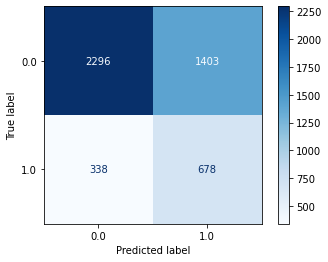

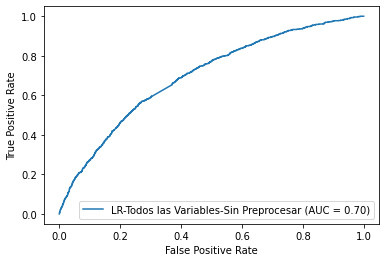

In [64]:
#Tuning de Hiperparametros
clf_lr_nopre_all = GridSearchCV(clf_lr, hiperparametros_lr,cv=5, n_jobs=-1,verbose=2)

#Fit
clf_lr_nopre_all.fit(x_train_nopre, y_train_nopre)

#Predict
y_pred_lr_nopre_all = clf_lr_nopre_all.predict(x_test_nopre)

#Metricas
print(classification_report(y_test_nopre, y_pred_lr_nopre_all))

#Matriz de confusion
plot_confusion_matrix(clf_lr_nopre_all, x_test_nopre, y_test_nopre,values_format = '.0f',cmap=plt.cm.Blues)

#Curva ROC
plot_roc_curve(clf_lr_nopre_all, x_test_nopre,y_test_nopre,name='LR-Todos las Variables-Sin Preprocesar')

#### Datos Preprocesados

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.4min finished
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3699
         1.0       0.22      1.00      0.35      1016

    accuracy                           0.22      4715
   macro avg       0.11      0.50      0.18      4715
weighted avg       0.05      0.22      0.08      4715



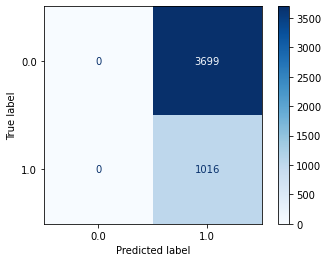

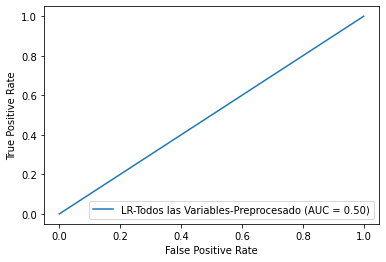

In [65]:
#Tuning de Hiperparametros
clf_lr_pre_all = GridSearchCV(clf_lr, hiperparametros_lr,cv=5, n_jobs=-1,verbose=2)

#Fit
clf_lr_pre_all.fit(x_train_pre, y_train_pre)

#Predict
y_pred_lr_pre_all = clf_lr_pre_all.predict(x_test_pre)

#Metricas
print(classification_report(y_test_pre, y_pred_lr_pre_all))

#Matriz de confusion
plot_confusion_matrix(clf_lr_pre_all, x_test_pre, y_test_pre,values_format = '.0f',cmap=plt.cm.Blues)

#Curva ROC
plot_roc_curve(clf_lr_pre_all,x_test_pre,y_test_pre,name='LR-Todos las Variables-Preprocesado')

### 5.2.2 Random Forest

In [66]:
clf_rf = RandomForestClassifier()
hiperparametros_rf = {'class_weight':['balanced'],
                      'max_depth':[5,10,15,None],
                      'random_state':[0]}

#### Datos sin Preprocesar

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.6min finished


              precision    recall  f1-score   support

         0.0       0.80      0.91      0.85      3699
         1.0       0.31      0.16      0.21      1016

    accuracy                           0.74      4715
   macro avg       0.56      0.53      0.53      4715
weighted avg       0.69      0.74      0.71      4715



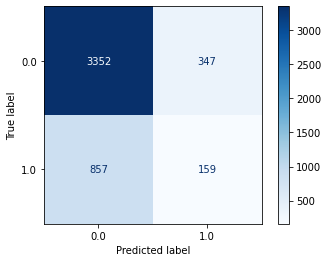

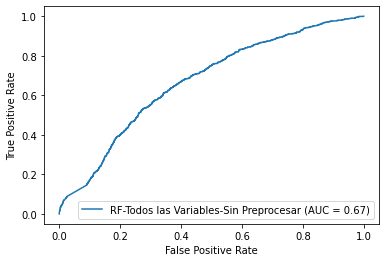

In [67]:
#Tuning de Hiperparametros
clf_rf_nopre_all = GridSearchCV(clf_rf, hiperparametros_rf,cv=5, n_jobs=-1,verbose=2)

#Fit
clf_rf_nopre_all.fit(x_train_nopre, y_train_nopre)

#Predict
y_pred_rf_nopre_all = clf_rf_nopre_all.predict(x_test_nopre)

#Metricas
print(classification_report(y_test_nopre, y_pred_rf_nopre_all))

#Matriz de confusion
plot_confusion_matrix(clf_rf_nopre_all, x_test_nopre, y_test_nopre,values_format = '.0f',cmap=plt.cm.Blues)

#Curva ROC
plot_roc_curve(clf_rf_nopre_all, x_test_nopre,y_test_nopre,name='RF-Todos las Variables-Sin Preprocesar')

#### Datos Preprocesados

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.6min finished


              precision    recall  f1-score   support

         0.0       0.79      0.92      0.85      3699
         1.0       0.28      0.11      0.16      1016

    accuracy                           0.75      4715
   macro avg       0.54      0.52      0.50      4715
weighted avg       0.68      0.75      0.70      4715



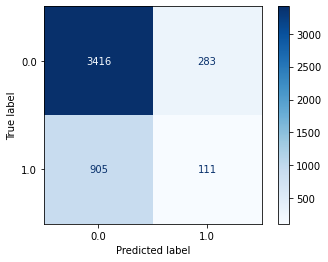

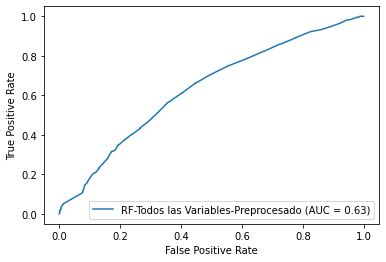

In [68]:
#Tuning de Hiperparametros
clf_rf_pre_all = GridSearchCV(clf_rf, hiperparametros_rf,cv=5, n_jobs=-1,verbose=2)

#Fit
clf_rf_pre_all.fit(x_train_pre, y_train_pre)

#Predict
y_pred_rf_pre_all = clf_rf_pre_all.predict(x_test_pre)

#Metricas
print(classification_report(y_test_pre, y_pred_rf_pre_all))

#Matriz de confusion
plot_confusion_matrix(clf_rf_pre_all, x_test_pre, y_test_pre,values_format = '.0f',cmap=plt.cm.Blues)

#Curva ROC
plot_roc_curve(clf_rf_pre_all, x_test_pre,y_test_pre,name='RF-Todos las Variables-Preprocesado')

### 5.2.3 Support Vector Machine

In [69]:
clf_svc = SVC()
hiperparametros_svc = {'class_weight':['balanced'],
                       'random_state':[0]}

#### Datos sin Preprocesar

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min finished


              precision    recall  f1-score   support

         0.0       0.87      0.67      0.76      3699
         1.0       0.35      0.65      0.45      1016

    accuracy                           0.66      4715
   macro avg       0.61      0.66      0.60      4715
weighted avg       0.76      0.66      0.69      4715



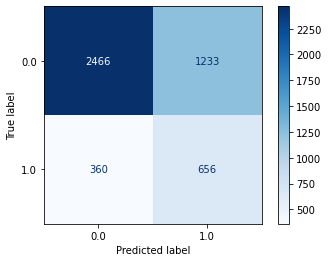

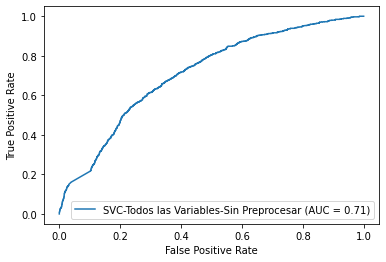

In [70]:
#Tuning de Hiperparametros
clf_svc_nopre_all = GridSearchCV(clf_svc, hiperparametros_svc,cv=5, n_jobs=-1,verbose=2)

#Fit
clf_svc_nopre_all.fit(x_train_nopre, y_train_nopre)

#Predict
y_pred_svc_nopre_all = clf_svc_nopre_all.predict(x_test_nopre)

#Metricas
print(classification_report(y_test_nopre, y_pred_svc_nopre_all))

#Matriz de confusion
plot_confusion_matrix(clf_svc_nopre_all, x_test_nopre, y_test_nopre,values_format = '.0f',cmap=plt.cm.Blues)

#Curva ROC
plot_roc_curve(clf_svc_nopre_all, x_test_nopre,y_test_nopre,name='SVC-Todos las Variables-Sin Preprocesar')

#### Datos Preprocesados

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.8min finished


              precision    recall  f1-score   support

         0.0       0.86      0.65      0.74      3699
         1.0       0.32      0.62      0.42      1016

    accuracy                           0.64      4715
   macro avg       0.59      0.63      0.58      4715
weighted avg       0.74      0.64      0.67      4715



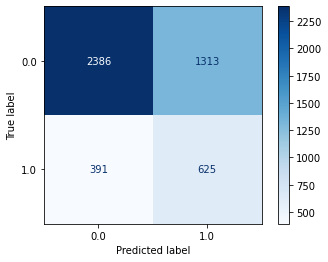

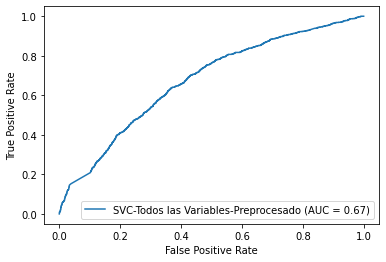

In [71]:
#Tuning de Hiperparametros
clf_svc_pre_all = GridSearchCV(clf_svc, hiperparametros_svc,cv=5, n_jobs=-1,verbose=2)

#Fit
clf_svc_pre_all.fit(x_train_pre, y_train_pre)

#Predict
y_pred_svc_pre_all = clf_svc_pre_all.predict(x_test_pre)

#Metricas
print(classification_report(y_test_pre, y_pred_svc_pre_all))

#Matriz de confusion
plot_confusion_matrix(clf_svc_pre_all, x_test_pre, y_test_pre,values_format = '.0f',cmap=plt.cm.Blues)

#Curva ROC
plot_roc_curve(clf_svc_pre_all, x_test_pre,y_test_pre,name='SVC-Todos las Variables-Preprocesado')

### 5.2.4 AdaBoost

In [72]:
clf_ada = AdaBoostClassifier()
hiperparametros_ada = {'random_state':[0]}

#### Datos sin Preprocesar

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   55.8s finished


              precision    recall  f1-score   support

         0.0       0.80      0.96      0.87      3699
         1.0       0.48      0.13      0.20      1016

    accuracy                           0.78      4715
   macro avg       0.64      0.55      0.54      4715
weighted avg       0.73      0.78      0.73      4715



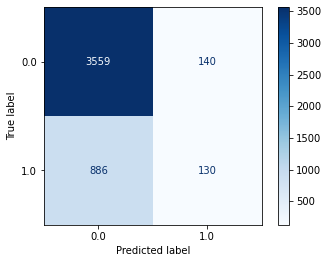

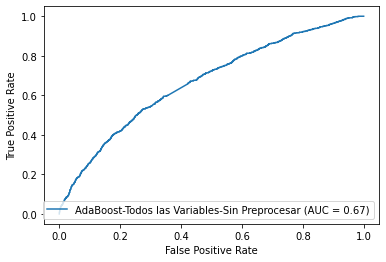

In [73]:
#Tuning de Hiperparametros
clf_ada_nopre_all = GridSearchCV(clf_ada, hiperparametros_ada,cv=5, n_jobs=-1,verbose=2)

#Fit
clf_ada_nopre_all.fit(x_train_nopre, y_train_nopre)

#Predict
y_pred_ada_nopre_all = clf_ada_nopre_all.predict(x_test_nopre)

#Metricas
print(classification_report(y_test_nopre, y_pred_ada_nopre_all))

#Matriz de confusion
plot_confusion_matrix(clf_ada_nopre_all, x_test_nopre, y_test_nopre,values_format = '.0f',cmap=plt.cm.Blues)

#Curva ROC
plot_roc_curve(clf_ada_nopre_all, x_test_nopre,y_test_nopre,name='AdaBoost-Todos las Variables-Sin Preprocesar')

#### Datos Preprocesados

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   55.1s finished


              precision    recall  f1-score   support

         0.0       0.79      0.98      0.88      3699
         1.0       0.51      0.08      0.14      1016

    accuracy                           0.79      4715
   macro avg       0.65      0.53      0.51      4715
weighted avg       0.73      0.79      0.72      4715



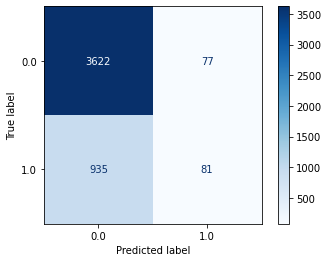

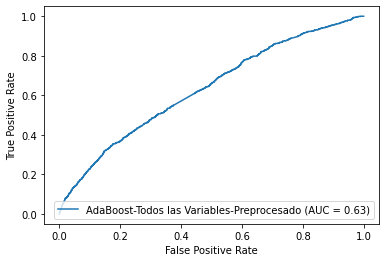

In [74]:
#Tuning de Hiperparametros
clf_ada_pre_all = GridSearchCV(clf_ada, hiperparametros_ada,cv=5, n_jobs=-1,verbose=2)

#Fit
clf_ada_pre_all.fit(x_train_pre, y_train_pre)

#Predict
y_pred_ada_pre_all = clf_ada_pre_all.predict(x_test_pre)

#Metricas
print(classification_report(y_test_pre, y_pred_ada_pre_all))

#Matriz de confusion
plot_confusion_matrix(clf_ada_pre_all, x_test_pre, y_test_pre,values_format = '.0f',cmap=plt.cm.Blues)

#Curva ROC
plot_roc_curve(clf_ada_pre_all, x_test_pre,y_test_pre,name='AdaBoost-Todos las Variables-Preprocesado')

### 5.2.5 Naive Bayes

In [75]:
clf_nb = GaussianNB()
hiperparametros_nb = {}

#### Datos sin Preprocesar

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


              precision    recall  f1-score   support

         0.0       0.85      0.41      0.56      3699
         1.0       0.26      0.74      0.38      1016

    accuracy                           0.48      4715
   macro avg       0.55      0.58      0.47      4715
weighted avg       0.72      0.48      0.52      4715



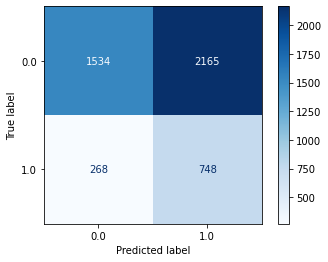

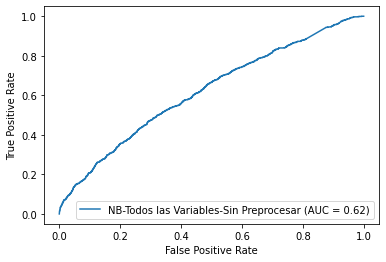

In [76]:
#Tuning de Hiperparametros
clf_nb_nopre_all = GridSearchCV(clf_nb, hiperparametros_nb,cv=5, n_jobs=-1,verbose=2)

#Fit
clf_nb_nopre_all.fit(x_train_nopre, y_train_nopre)

#Predict
y_pred_nb_nopre_all = clf_nb_nopre_all.predict(x_test_nopre)

#Metricas
print(classification_report(y_test_nopre, y_pred_nb_nopre_all))

#Matriz de confusion
plot_confusion_matrix(clf_nb_nopre_all, x_test_nopre, y_test_nopre,values_format = '.0f',cmap=plt.cm.Blues)

#Curva ROC
plot_roc_curve(clf_nb_nopre_all, x_test_nopre,y_test_nopre,name='NB-Todos las Variables-Sin Preprocesar')

#### Datos Preprocesados

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


              precision    recall  f1-score   support

         0.0       0.85      0.44      0.58      3699
         1.0       0.26      0.71      0.38      1016

    accuracy                           0.50      4715
   macro avg       0.55      0.58      0.48      4715
weighted avg       0.72      0.50      0.54      4715



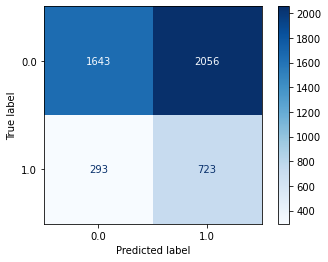

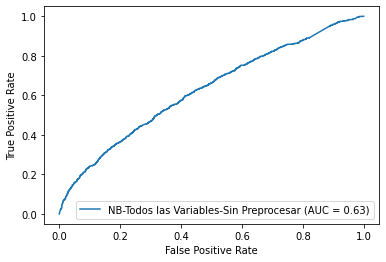

In [77]:
#Tuning de Hiperparametros
clf_nb_pre_all = GridSearchCV(clf_nb, hiperparametros_nb,cv=5, n_jobs=-1,verbose=2)

#Fit
clf_nb_pre_all.fit(x_train_pre, y_train_pre)

#Predict
y_pred_nb_pre_all = clf_nb_pre_all.predict(x_test_pre)

#Metricas
print(classification_report(y_test_pre, y_pred_nb_pre_all))

#Matriz de confusion
plot_confusion_matrix(clf_nb_pre_all, x_test_pre, y_test_pre,values_format = '.0f',cmap=plt.cm.Blues)

#Curva ROC
plot_roc_curve(clf_nb_pre_all, x_test_pre,y_test_pre,name='NB-Todos las Variables-Sin Preprocesar')

## 5.3 Modelos de clasificacion - Feature reduction con PCA

En esta seccion planteo una reduccion de la dimensionalidad en los features utilizando PCA. Para esto utiulizo solos los feautures numericos, los cuales se vio anteriormente que corresponden a las representaciones del texto por deep learning junto a polaridad / subjetividad tanto para texto preprocesado como no preprocesado.

### 5.3.1 Dataset sin Preprocesar

In [78]:
scaler_nopre = StandardScaler()

In [79]:
#Para realizar PCA necesito escalar los datos

x_num_nopre_scale = scaler_nopre.fit_transform(x_num_nopre)

In [80]:
#Calculo la varianza explicada por todas las componentes principales y lo observo en un grafico acumulado

var_acum_nopre = PCA()
var_acum_nopre.fit(x_num_nopre_scale)
var_cumul_nopre = np.cumsum(var_acum_nopre.explained_variance_ratio_)

px.area(
    x=range(1, var_cumul_nopre.shape[0] + 1),
    y=var_cumul_nopre,
    labels={"x": "# Componentes", "y": "Varianza Explicada"})

A modo de ejemplo se observa que para lograr un 80% de varianza explicada es necesario aproximadamente las primeras 73 componentes principales

In [81]:
#Me quedo con la cantidad n de componentes principales que explican el 85% de la varianza

pca_nopre = PCA(0.85)

In [82]:
#Obtengo los vectores en la representacion PCA para los datasets de train y test

x_train_nopre_pca = pca_nopre.fit_transform(x_train_nopre_num_scale)
x_test_nopre_pca = pca_nopre.transform(x_test_nopre_num_scale)

In [83]:
#Observo el primer vector del dataset de train

x_train_nopre_pca[0]

array([-2.51758122, -3.98824686, -2.20275227, -0.45622998, -2.02884173,
       -2.72111677, -2.74141263,  1.07258492,  2.19729684, -0.09751791,
        0.93861394,  0.26019148,  2.02649297,  0.15023991,  1.44946682,
       -2.14491386, -0.02225845, -0.70778816, -0.68292582,  0.38929625,
        0.29009474,  0.49290975, -0.69171341, -2.44626267,  0.34350566,
        0.81521118,  1.51138472, -1.17072117,  0.0869072 ,  0.21851358,
       -0.9429414 ,  1.63235254,  0.31484053, -1.35582647, -0.67142479,
        0.1988629 , -1.59021457, -0.58296979, -0.6180598 ,  0.07050557,
       -0.19165914,  1.08834716,  0.76231133,  0.33052689,  0.03901592,
       -0.11775876, -0.68273311, -0.26621812,  0.14988678,  0.66191567,
       -0.05840041, -0.50585309, -0.51034646,  0.63405994, -0.5161632 ,
       -0.02213985,  0.26304084,  0.14176309, -0.89879215,  0.04701043,
        0.45887988, -0.69187292, -0.48073806, -0.14137938, -0.27391288,
        0.12008474,  0.22060624,  0.67905568,  0.47225052,  0.24

### 5.3.2 Dataset Preprocesado

In [84]:
#Me quedo con la cantidad n de componentes principales que explican el 85% de la varianza

pca_pre = PCA(0.85)

In [85]:
#Obtengo los vectores en la representacion PCA para los datasets de train y test

x_train_pre_pca = pca_pre.fit_transform(x_train_pre_num_scale)
x_test_pre_pca = pca_pre.transform(x_test_pre_num_scale)

In [86]:
#Observo el primer vector del dataset de train

x_train_pre_pca[0]

array([-4.27263014e+00, -2.50435552e+00,  1.51761710e+00, -3.24165215e+00,
        8.45518257e-01, -2.84596531e-01,  4.00946293e+00, -1.59926791e-03,
       -1.22447376e+00, -7.22963603e-01, -1.88264173e+00, -1.86194267e+00,
        5.29353936e-01, -1.71403164e+00,  1.84880436e+00, -2.35402399e-01,
       -5.37666311e-01,  4.74406861e+00,  1.04129547e+00,  3.03570791e-01,
       -4.73273641e-01, -1.78024828e-01,  2.41601293e-01, -2.14129869e-01,
       -9.41639750e-01, -8.28689825e-01, -6.48497363e-01,  2.95979133e-02,
       -1.85383963e+00, -6.79744822e-01,  2.04988554e-01, -1.10002730e-01,
        2.97198611e-01,  1.24053740e+00, -1.05216329e-01,  3.90246489e-01,
       -1.27873976e-01, -1.41185847e+00,  1.44755400e-01,  4.75059812e-01,
        4.64766178e-01, -8.58174932e-01,  5.49419821e-01,  4.43541936e-01,
       -9.22908893e-01,  2.78807061e-01,  3.94504455e-01, -1.10392358e-01,
       -1.07140256e-01,  1.75095840e-01, -2.08721396e-01, -4.04511049e-01,
       -1.12772570e-01, -

### 5.3.1 Logistic Regression

In [87]:
clf_lr = LogisticRegression()
hiperparametros_lr = {'penalty':['l1','l2'],
                      'C': np.linspace(0.0001,1,5),
                      'class_weight':['balanced'],
                      'solver':['saga'],
                      'random_state':[0]}

#### Datos sin Preprocesar

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    7.3s finished


              precision    recall  f1-score   support

         0.0       0.86      0.61      0.72      3699
         1.0       0.31      0.65      0.42      1016

    accuracy                           0.62      4715
   macro avg       0.59      0.63      0.57      4715
weighted avg       0.75      0.62      0.65      4715



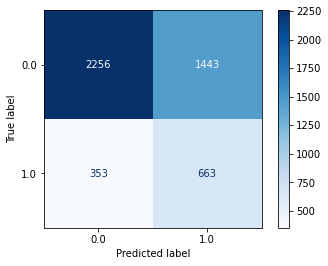

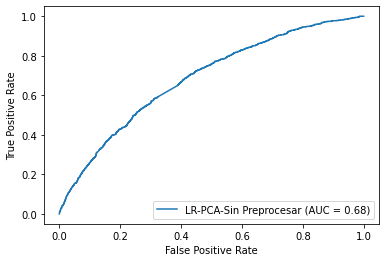

In [88]:
#Tuning de Hiperparametros
clf_lr_nopre_pca = GridSearchCV(clf_lr, hiperparametros_lr,cv=5, n_jobs=-1,verbose=2)

#Fit
clf_lr_nopre_pca.fit(x_train_nopre_pca, y_train_nopre)

#Predict
y_pred_lr_nopre_pca = clf_lr_nopre_pca.predict(x_test_nopre_pca)

#Metricas
print(classification_report(y_test_nopre, y_pred_lr_nopre_pca))

#Matriz de confusion
plot_confusion_matrix(clf_lr_nopre_pca, x_test_nopre_pca, y_test_nopre,values_format = '.0f',cmap=plt.cm.Blues)

#Curva ROC
plot_roc_curve(clf_lr_nopre_pca, x_test_nopre_pca,y_test_nopre,name='LR-PCA-Sin Preprocesar')

#### Datos Preprocesados

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.6s finished


              precision    recall  f1-score   support

         0.0       0.84      0.66      0.74      3699
         1.0       0.31      0.55      0.39      1016

    accuracy                           0.63      4715
   macro avg       0.57      0.60      0.57      4715
weighted avg       0.73      0.63      0.66      4715



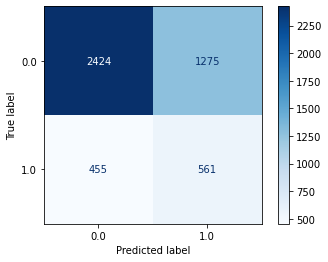

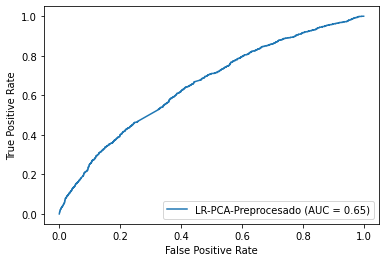

In [89]:
#Tuning de Hiperparametros
clf_lr_pre_pca = GridSearchCV(clf_lr, hiperparametros_lr,cv=5, n_jobs=-1,verbose=2)

#Fit
clf_lr_pre_pca.fit(x_train_pre_pca, y_train_pre)

#Predict
y_pred_lr_pre_pca = clf_lr_pre_pca.predict(x_test_pre_pca)

#Metricas
print(classification_report(y_test_pre, y_pred_lr_pre_pca))

#Matriz de confusion
plot_confusion_matrix(clf_lr_pre_pca, x_test_pre_pca, y_test_pre,values_format = '.0f',cmap=plt.cm.Blues)

#Curva ROC
plot_roc_curve(clf_lr_pre_pca, x_test_pre_pca,y_test_pre,name='LR-PCA-Preprocesado')

### 5.3.2 Random Forest

In [90]:
clf_rf = RandomForestClassifier()
hiperparametros_rf = {'class_weight':['balanced'],
                      'max_depth':[5,10,15,None],
                      'random_state':[0]}

#### Datos sin Preprocesar

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   49.2s finished


              precision    recall  f1-score   support

         0.0       0.79      0.93      0.85      3699
         1.0       0.24      0.08      0.12      1016

    accuracy                           0.75      4715
   macro avg       0.51      0.51      0.49      4715
weighted avg       0.67      0.75      0.69      4715



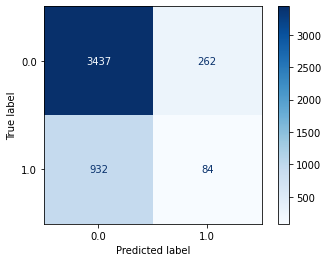

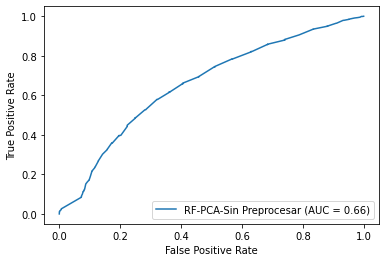

In [91]:
#Tuning de Hiperparametros
clf_rf_nopre_pca = GridSearchCV(clf_rf, hiperparametros_rf,cv=5, n_jobs=-1,verbose=2)

#Fit
clf_rf_nopre_pca.fit(x_train_nopre_pca, y_train_nopre)

#Predict
y_pred_rf_nopre_pca = clf_rf_nopre_pca.predict(x_test_nopre_pca)

#Metricas
print(classification_report(y_test_nopre, y_pred_rf_nopre_pca))

#Matriz de confusion
plot_confusion_matrix(clf_rf_nopre_pca, x_test_nopre_pca, y_test_nopre,values_format = '.0f',cmap=plt.cm.Blues)

#Curva ROC
plot_roc_curve(clf_rf_nopre_pca, x_test_nopre_pca,y_test_nopre,name='RF-PCA-Sin Preprocesar')

#### Datos Preprocesados

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   58.3s finished


              precision    recall  f1-score   support

         0.0       0.79      0.93      0.85      3699
         1.0       0.25      0.09      0.14      1016

    accuracy                           0.75      4715
   macro avg       0.52      0.51      0.49      4715
weighted avg       0.67      0.75      0.70      4715



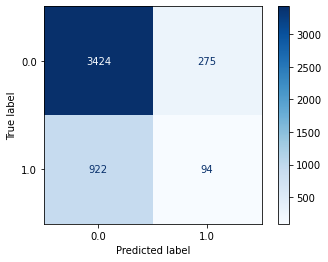

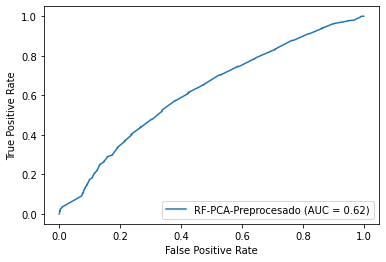

In [92]:
#Tuning de Hiperparametros
clf_rf_pre_pca = GridSearchCV(clf_rf, hiperparametros_rf,cv=5, n_jobs=-1,verbose=2)

#Fit
clf_rf_pre_pca.fit(x_train_pre_pca, y_train_pre)

#Predict
y_pred_rf_pre_pca = clf_rf_pre_pca.predict(x_test_pre_pca)

#Metricas
print(classification_report(y_test_pre, y_pred_rf_pre_pca))

#Matriz de confusion
plot_confusion_matrix(clf_rf_pre_pca, x_test_pre_pca, y_test_pre,values_format = '.0f',cmap=plt.cm.Blues)

#Curva ROC
plot_roc_curve(clf_rf_pre_pca, x_test_pre_pca,y_test_pre,name='RF-PCA-Preprocesado')

### 5.3.3 Support Vector Machine

In [93]:
clf_svc = SVC()
hiperparametros_svc = {'class_weight':['balanced'],
                       'random_state':[0]}

#### Datos sin Preprocesar

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   46.0s finished


              precision    recall  f1-score   support

         0.0       0.87      0.64      0.74      3699
         1.0       0.34      0.66      0.44      1016

    accuracy                           0.65      4715
   macro avg       0.60      0.65      0.59      4715
weighted avg       0.76      0.65      0.68      4715



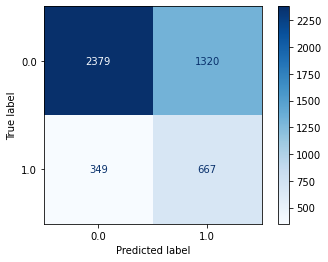

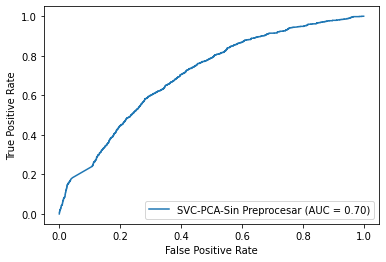

In [94]:
#Tuning de Hiperparametros
clf_svc_nopre_pca = GridSearchCV(clf_svc, hiperparametros_svc,cv=5, n_jobs=-1,verbose=2)

#Fit
clf_svc_nopre_pca.fit(x_train_nopre_pca, y_train_nopre)

#Predict
y_pred_svc_nopre_pca = clf_svc_nopre_pca.predict(x_test_nopre_pca)

#Metricas
print(classification_report(y_test_nopre, y_pred_svc_nopre_pca))

#Matriz de confusion
plot_confusion_matrix(clf_svc_nopre_pca, x_test_nopre_pca, y_test_nopre,values_format = '.0f',cmap=plt.cm.Blues)

#Curva ROC
plot_roc_curve(clf_svc_nopre_pca, x_test_nopre_pca,y_test_nopre,name='SVC-PCA-Sin Preprocesar')

#### Datos Preprocesados

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


              precision    recall  f1-score   support

         0.0       0.86      0.63      0.72      3699
         1.0       0.32      0.63      0.42      1016

    accuracy                           0.63      4715
   macro avg       0.59      0.63      0.57      4715
weighted avg       0.74      0.63      0.66      4715



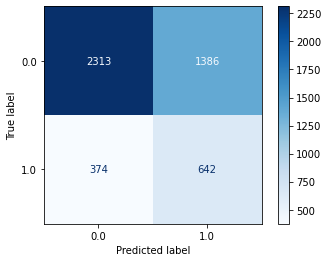

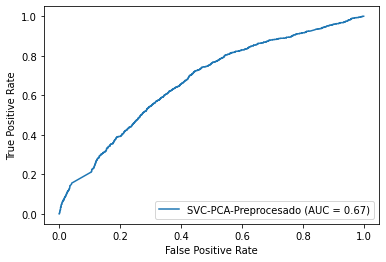

In [95]:
#Tuning de Hiperparametros
clf_svc_pre_pca = GridSearchCV(clf_svc, hiperparametros_svc,cv=5, n_jobs=-1,verbose=2)

#Fit
clf_svc_pre_pca.fit(x_train_pre_pca, y_train_pre)

#Predict
y_pred_svc_pre_pca = clf_svc_pre_pca.predict(x_test_pre_pca)

#Metricas
print(classification_report(y_test_pre, y_pred_svc_pre_pca))

#Matriz de confusion
plot_confusion_matrix(clf_svc_pre_pca, x_test_pre_pca, y_test_pre,values_format = '.0f',cmap=plt.cm.Blues)

#Curva ROC
plot_roc_curve(clf_svc_pre_pca, x_test_pre_pca,y_test_pre,name='SVC-PCA-Preprocesado')

### 5.3.4 AdaBoost

In [96]:
clf_ada = AdaBoostClassifier()
hiperparametros_ada = {'random_state':[0]}

#### Datos sin Preprocesar

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.8s finished


              precision    recall  f1-score   support

         0.0       0.80      0.97      0.88      3699
         1.0       0.50      0.10      0.17      1016

    accuracy                           0.78      4715
   macro avg       0.65      0.54      0.52      4715
weighted avg       0.73      0.78      0.72      4715



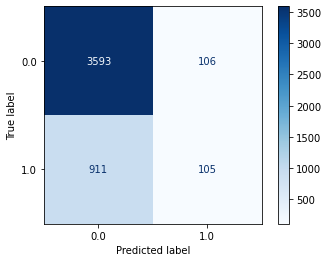

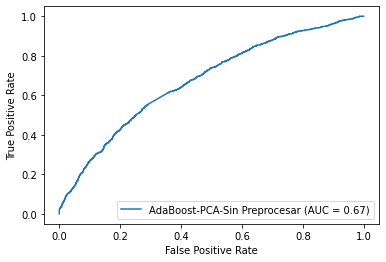

In [97]:
#Tuning de Hiperparametros
clf_ada_nopre_pca = GridSearchCV(clf_ada, hiperparametros_ada,cv=5, n_jobs=-1,verbose=2)

#Fit
clf_ada_nopre_pca.fit(x_train_nopre_pca, y_train_nopre)

#Predict
y_pred_ada_nopre_pca = clf_ada_nopre_pca.predict(x_test_nopre_pca)

#Metricas
print(classification_report(y_test_nopre, y_pred_ada_nopre_pca))

#Matriz de confusion
plot_confusion_matrix(clf_ada_nopre_pca, x_test_nopre_pca, y_test_nopre,values_format = '.0f',cmap=plt.cm.Blues)

#Curva ROC
plot_roc_curve(clf_ada_nopre_pca, x_test_nopre_pca,y_test_nopre,name='AdaBoost-PCA-Sin Preprocesar')

#### Datos Preprocesado

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.9s finished


              precision    recall  f1-score   support

         0.0       0.79      0.98      0.88      3699
         1.0       0.52      0.08      0.14      1016

    accuracy                           0.79      4715
   macro avg       0.66      0.53      0.51      4715
weighted avg       0.74      0.79      0.72      4715



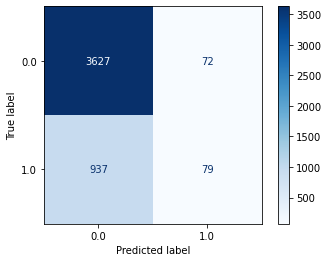

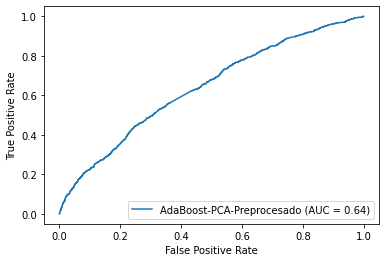

In [98]:
#Tuning de Hiperparametros
clf_ada_pre_pca = GridSearchCV(clf_ada, hiperparametros_ada,cv=5, n_jobs=-1,verbose=2)

#Fit
clf_ada_pre_pca.fit(x_train_pre_pca, y_train_pre)

#Predict
y_pred_ada_pre_pca = clf_ada_pre_pca.predict(x_test_pre_pca)

#Metricas
print(classification_report(y_test_pre, y_pred_ada_pre_pca))

#Matriz de confusion
plot_confusion_matrix(clf_ada_pre_pca, x_test_pre_pca, y_test_pre,values_format = '.0f',cmap=plt.cm.Blues)

#Curva ROC
plot_roc_curve(clf_ada_pre_pca, x_test_pre_pca,y_test_pre,name='AdaBoost-PCA-Preprocesado')

### 5.3.5 Naive Bayes

In [99]:
clf_nb = GaussianNB()
hiperparametros_nb = {}

#### Datos sin Preprocesar

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


              precision    recall  f1-score   support

         0.0       0.81      0.38      0.52      3699
         1.0       0.23      0.69      0.35      1016

    accuracy                           0.44      4715
   macro avg       0.52      0.53      0.43      4715
weighted avg       0.69      0.44      0.48      4715



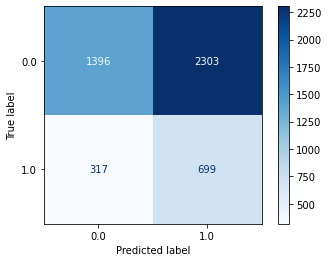

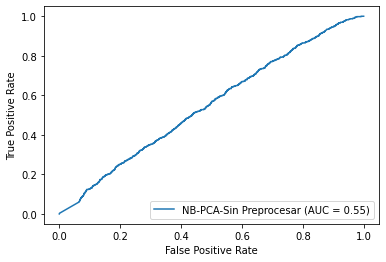

In [100]:
#Tuning de Hiperparametros
clf_nb_nopre_pca = GridSearchCV(clf_nb, hiperparametros_nb,cv=5, n_jobs=-1,verbose=2)

#Fit
clf_nb_nopre_pca.fit(x_train_nopre_pca, y_train_nopre)

#Predict
y_pred_nb_nopre_pca = clf_nb_nopre_pca.predict(x_test_nopre_pca)

#Metricas
print(classification_report(y_test_nopre, y_pred_nb_nopre_pca))

#Matriz de confusion
plot_confusion_matrix(clf_nb_nopre_pca, x_test_nopre_pca, y_test_nopre,values_format = '.0f',cmap=plt.cm.Blues)

#Curva ROC
plot_roc_curve(clf_nb_nopre_pca, x_test_nopre_pca,y_test_nopre,name='NB-PCA-Sin Preprocesar')

#### Datos Preprocesados

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


              precision    recall  f1-score   support

         0.0       0.82      0.38      0.52      3699
         1.0       0.24      0.70      0.35      1016

    accuracy                           0.45      4715
   macro avg       0.53      0.54      0.43      4715
weighted avg       0.69      0.45      0.48      4715



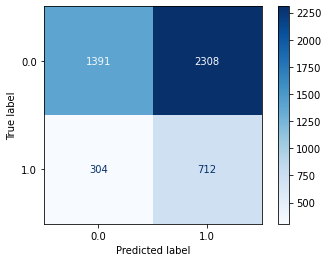

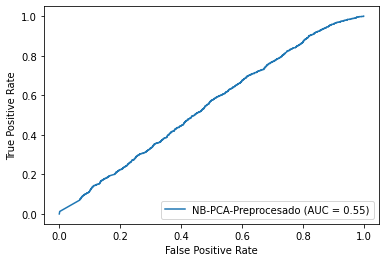

In [101]:
#Tuning de Hiperparametros
clf_nb_pre_pca = GridSearchCV(clf_nb, hiperparametros_nb,cv=5, n_jobs=-1,verbose=2)

#Fit
clf_nb_pre_pca.fit(x_train_pre_pca, y_train_pre)

#Predict
y_pred_nb_pre_pca = clf_nb_pre_pca.predict(x_test_pre_pca)

#Metricas
print(classification_report(y_test_pre, y_pred_nb_pre_pca))

#Matriz de confusion
plot_confusion_matrix(clf_nb_pre_pca, x_test_pre_pca, y_test_pre,values_format = '.0f',cmap=plt.cm.Blues)

#Curva ROC
plot_roc_curve(clf_nb_pre_pca, x_test_pre_pca,y_test_pre,name='NB-PCA-Preprocesado')

## 5.4 Over-Samplig

Considerando el desbalanceo de clases presente en el target exploro la posibilidad de realizar Over Sanpling sobre las representaciones vectoriales y feaures adicionales del conjunto de entrenamiento para los datos preprocesados. El conjunto de test sobre el cual se obtienen las metricas representativas del modelo no se realiza over sampling

In [102]:
#Importo las librerias

import imblearn
from imblearn.over_sampling import BorderlineSMOTE

### Datos Preprocesados

In [103]:
#Realizo over sampling sobre el conjunto de test

x_train_pre_resampled, y_train_pre_resampled = BorderlineSMOTE().fit_resample(x_train_pre, y_train_pre)

In [104]:
#Observo el tamaño de los dataframes

print(x_train_pre_resampled.shape)
print(y_train_pre_resampled.shape)

(22192, 304)
(22192,)


In [105]:
y_train_pre.value_counts()

0.0    11096
1.0     3049
Name: is_hate, dtype: int64

In [106]:
#Observo como queda el balance de clases en el target

y_train_pre_resampled.value_counts()

0.0    11096
1.0    11096
Name: is_hate, dtype: int64

### 5.4.1 Logistic Regression

In [107]:
clf_lr = LogisticRegression()
hiperparametros_lr = {'penalty':['l1','l2'],
                      'C': np.linspace(0.0001,1,5),
                      'class_weight':['balanced'],
                      'solver':['saga'],
                      'random_state':[0]}

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.3min finished


              precision    recall  f1-score   support

         0.0       0.84      0.63      0.72      3699
         1.0       0.29      0.56      0.38      1016

    accuracy                           0.61      4715
   macro avg       0.57      0.59      0.55      4715
weighted avg       0.72      0.61      0.65      4715



/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



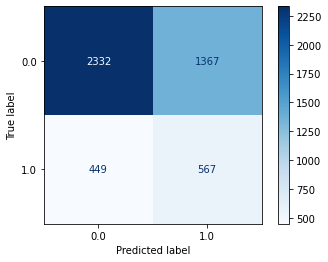

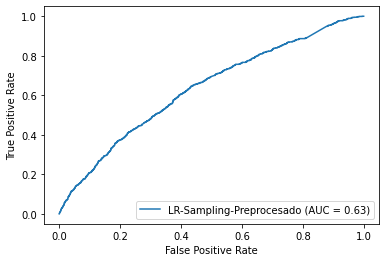

In [108]:
#Tuning de Hiperparametros
clf_lr_pre_sampling = GridSearchCV(clf_lr, hiperparametros_lr,cv=5, n_jobs=-1,verbose=2)

#Fit
clf_lr_pre_sampling.fit(x_train_pre_resampled, y_train_pre_resampled)

#Predict
y_pred_lr_pre_sampling = clf_lr_pre_sampling.predict(x_test_pre)

#Metricas
print(classification_report(y_test_pre, y_pred_lr_pre_sampling))

#Matriz de confusion
plot_confusion_matrix(clf_lr_pre_sampling, x_test_pre, y_test_pre,values_format = '.0f',cmap=plt.cm.Blues)

#Curva ROC
plot_roc_curve(clf_lr_pre_sampling, x_test_pre,y_test_pre,name='LR-Sampling-Preprocesado')

### 5.4.2 Random Forest

In [109]:
clf_rf = RandomForestClassifier()
hiperparametros_rf = {'class_weight':['balanced'],
                      'max_depth':[5,10,15,None],
                      'random_state':[0]}

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  3.2min finished


              precision    recall  f1-score   support

         0.0       0.81      0.90      0.85      3699
         1.0       0.38      0.21      0.27      1016

    accuracy                           0.75      4715
   macro avg       0.59      0.56      0.56      4715
weighted avg       0.71      0.75      0.73      4715



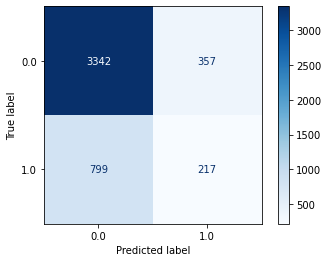

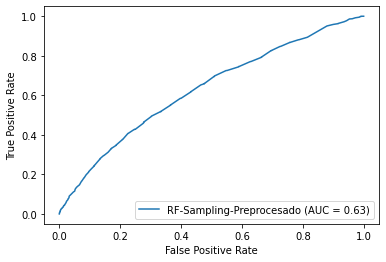

In [110]:
#Tuning de Hiperparametros
clf_rf_pre_sampling = GridSearchCV(clf_rf, hiperparametros_rf,cv=5, n_jobs=-1,verbose=2)

#Fit
clf_rf_pre_sampling.fit(x_train_pre_resampled, y_train_pre_resampled)

#Predict
y_pred_rf_pre_sampling = clf_rf_pre_sampling.predict(x_test_pre)

#Metricas
print(classification_report(y_test_pre, y_pred_rf_pre_sampling))

#Matriz de confusion
plot_confusion_matrix(clf_rf_pre_sampling, x_test_pre, y_test_pre,values_format = '.0f',cmap=plt.cm.Blues)

#Curva ROC
plot_roc_curve(clf_rf_pre_sampling, x_test_pre,y_test_pre,name='RF-Sampling-Preprocesado')

### 5.4.3 Support Vector

In [111]:
clf_svc = SVC()
hiperparametros_svc = {'class_weight':['balanced'],
                       'random_state':[0]}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.0min finished


              precision    recall  f1-score   support

         0.0       0.84      0.73      0.78      3699
         1.0       0.33      0.49      0.40      1016

    accuracy                           0.68      4715
   macro avg       0.59      0.61      0.59      4715
weighted avg       0.73      0.68      0.70      4715



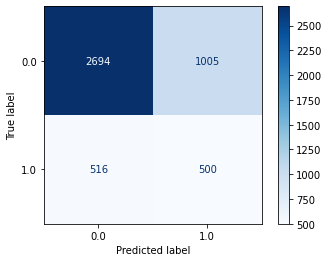

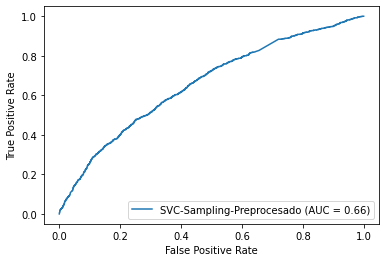

In [112]:
#Tuning de Hiperparametros
clf_svc_pre_sampling = GridSearchCV(clf_svc, hiperparametros_svc,cv=5, n_jobs=-1,verbose=2)

#Fit
clf_svc_pre_sampling.fit(x_train_pre_resampled, y_train_pre_resampled)

#Predict
y_pred_svc_pre_sampling = clf_svc_pre_sampling.predict(x_test_pre)

#Metricas
print(classification_report(y_test_pre, y_pred_svc_pre_sampling))

#Matriz de confusion
plot_confusion_matrix(clf_svc_pre_sampling, x_test_pre, y_test_pre,values_format = '.0f',cmap=plt.cm.Blues)

#Curva ROC
plot_roc_curve(clf_svc_pre_sampling, x_test_pre,y_test_pre,name='SVC-Sampling-Preprocesado')

### 5.4.4 AdaBoost

In [113]:
clf_ada = AdaBoostClassifier()
hiperparametros_ada = {'random_state':[0]}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


              precision    recall  f1-score   support

         0.0       0.83      0.73      0.78      3699
         1.0       0.31      0.45      0.37      1016

    accuracy                           0.67      4715
   macro avg       0.57      0.59      0.57      4715
weighted avg       0.72      0.67      0.69      4715



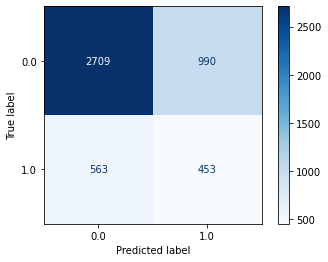

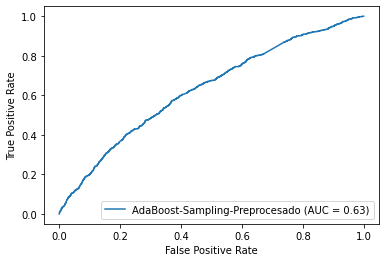

In [114]:
#Tuning de Hiperparametros
clf_ada_pre_sampling = GridSearchCV(clf_ada, hiperparametros_ada,cv=5, n_jobs=-1,verbose=2)

#Fit
clf_ada_pre_sampling.fit(x_train_pre_resampled, y_train_pre_resampled)

#Predict
y_pred_ada_pre_sampling = clf_ada_pre_sampling.predict(x_test_pre)

#Metricas
print(classification_report(y_test_pre, y_pred_ada_pre_sampling))

#Matriz de confusion
plot_confusion_matrix(clf_ada_pre_sampling, x_test_pre, y_test_pre,values_format = '.0f',cmap=plt.cm.Blues)

#Curva ROC
plot_roc_curve(clf_ada_pre_sampling, x_test_pre,y_test_pre,name='AdaBoost-Sampling-Preprocesado')

### 5.4.5 Naive Bayes

In [115]:
clf_nb = GaussianNB()
hiperparametros_nb = {}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


              precision    recall  f1-score   support

         0.0       0.81      0.33      0.47      3699
         1.0       0.23      0.71      0.34      1016

    accuracy                           0.42      4715
   macro avg       0.52      0.52      0.41      4715
weighted avg       0.68      0.42      0.44      4715



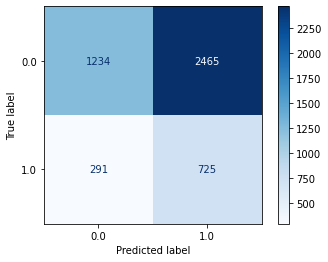

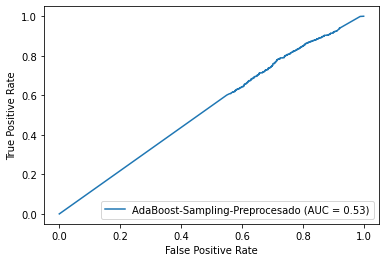

In [116]:
#Tuning de Hiperparametros
clf_nb_pre_sampling = GridSearchCV(clf_nb, hiperparametros_nb,cv=5, n_jobs=-1,verbose=2)

#Fit
clf_nb_pre_sampling.fit(x_train_pre_resampled, y_train_pre_resampled)

#Predict
y_pred_nb_pre_sampling = clf_nb_pre_sampling.predict(x_test_pre)

#Metricas
print(classification_report(y_test_pre, y_pred_nb_pre_sampling))

#Matriz de confusion
plot_confusion_matrix(clf_nb_pre_sampling, x_test_pre, y_test_pre,values_format = '.0f',cmap=plt.cm.Blues)

#Curva ROC
plot_roc_curve(clf_nb_pre_sampling, x_test_pre,y_test_pre,name='AdaBoost-Sampling-Preprocesado')

# 6. Conclusiones

Luego del analisis realizado se observa:

1. Trabajar con datos correspondiente a texto incorpora, con respecto a datos de tipo tabular, dificultades adicionales en etapas tempranas como ser el preprocesamiento y la represetancion del texto en forma numerica. Esto sin duda represento un gran desafio y termino siendo determinante en los resultados ontenidos en etapas posteriores.
2. La eleccion de la correcta representacion de los textos es importante desde el punto de vista computacional: En mi caso no fue posible, mediante el hardware provisto por Colab y Kaggle, manejar las representaciones TF-IDF de los comentarios preprocesados y tuve que recurrir a una representacion compacta (vectorial) mediante deep learning
3. Como era de esperar de un caso real (esta no fue la exepcion) la existencia de desbalance en las clases del Target incorpora desafios adicionales con respecto a las metricas a utilizar y tecnicas para su manejo.
4. Se exploraron 5 algoritmos:
    * Logistic Regression: 
        * Tiene resultados aceptables de Recall para ambas clases 
        * Tiene valores bajos de Precision para la clase minoritaria (Target = 1)
        * Un caso particular se observa para cuando se utilizan todos los feaures y texto preprocesado donde para la clase mayoritaria todas las metricas son 0
    * Random Forest:
        * Tiene valores bajos en todas las metricas para la clase minoritaria (Target = 1)
        * Tiene muy buenos resultados en todas las metricas para la clase mayoritaria (Target = 0)
    * Support Vector Machine:
        * Tiene comportamiento similar a Logistic Regression   
        
    * AdaBoost:        
        * Tiene comportamiento similar a Random Forest
        
    * Naive Bayes:        
        * Es el modelo que obtiene mayores valores de Recall para la clase minirotoria (Target = 1)
        * Tiene pobre desempeño para la clase mayoritaria (Target = 0)
5. El uso de Over Sampling no resulto en mejora de las metricas en los modelos
6. En general los resulados obtenidos son parcialmente aceptables y considero necesario realizar:
    * Incorporar nuevas features existententes o sinteticas (feature engineering)
    * Mejorar las etapas de preprocesamiento de texto
    * Probar con otras representaciones de texto
    * Probar otros algoritmos 

Comentario Final: Los TP's resultaron un gran desafio a resolver y eso resulto en un gran aprendizaje personal. Esto demuestra la complejidad al trabajar con tareas de NLP.